In [1]:
import jax 
from utils.train import * 
from utils.general import *
from utils.eval import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

2023-11-01 02:54:18.779970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
config = {
    "debug":True,
    "N": 5,
    "feature_dim": 3, # this the number of classes under different features set, e.g. dim = 3 for 0, 1, 2
    "emb_dim":6,
    "qkv_features":6,
    "out_features":6,
    "num_episodes": 4000000,
    "mlp_hidden": 128,
    "batch_size": 500,
    "learning_rate": 0.0001,
    "num_agents": 4,
    "PRNGkey": 0,
    "eval_PRNGkey":12345,
    "num_heads": 1,
    "eval_runs":100,
    "eps_min":0.01,
    "eps_max":0.95,
    "K":50000,
    "logging":True
    }

init_sp = jnp.zeros((config["batch_size"], 2 * config["feature_dim"]), jnp.float32)
init_h1 = jnp.zeros((config["batch_size"], config["N"], 2 * config["feature_dim"]), jnp.float32)
init_h2 = jnp.zeros((config["batch_size"], config["N"], 2 * config["feature_dim"]), jnp.float32)
init_rng = jax.random.PRNGKey(0)


hinter = A2I(hidden=config["mlp_hidden"],
                 num_heads=config["num_heads"],
                 batch_size=config["batch_size"],
                 emb_dim=config["emb_dim"],
                 N=config["N"],
                 qkv_features=config["qkv_features"],
                 out_features=config["out_features"])
        
        
        
guesser = A2I(hidden=config["mlp_hidden"],
				num_heads=config["num_heads"],
				batch_size=config["batch_size"],
				emb_dim=config["emb_dim"],
				N=config["N"],
				qkv_features=config["qkv_features"],
				out_features=config["out_features"])


In [19]:
h_tree = load_trainstate("result/2023-10-31-SA2I/hinter_2")
g_tree = load_trainstate("result/2023-10-31-SA2I/guesser_2")

t_state_h = create_train_state(hinter, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=h_tree["params"])
t_state_g = create_train_state(guesser, init_sp, init_h1, init_h2, init_rng, config["learning_rate"], params=g_tree["params"] )

100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


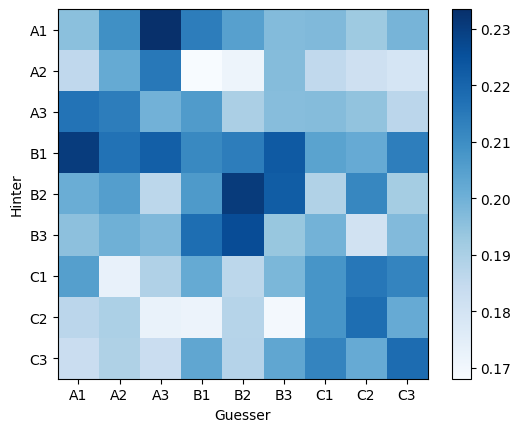

In [20]:
rewards, conditional_prob = play_eval(t_state_h, t_state_g, init_rng, config)
labels = [f"{char}{num}" for char in "ABC" for num in range(1, 4)]
fig, ax = plt.subplots()
cax = ax.imshow(conditional_prob, cmap='Blues')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Guesser')
ax.set_ylabel('Hinter')
cbar = fig.colorbar(cax, ax=ax)

plt.show()